# Kinetic simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

from tapqir.models import Cosmos
from tapqir.utils.imscroll import count_intervals, time_to_first_binding, \
    association_rate, dissociation_rate, bootstrap, posterior_estimate, \
    bound_dwell_times, unbound_dwell_times, sample_and_bootstrap

from tapqir.utils.mle_analysis import train, double_exp_model, double_exp_guide

In [2]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from tapqir.models import Cosmos

## Load results

In [3]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [4]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("kon"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs32/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["kon"] = truth[data_path.name]["kon"]
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        model = Cosmos()
        model.load(data_path, True, "cpu")
        model.load_parameters(param_path)
        mask = torch.from_numpy(model.data.labels["z"])
        samples = torch.masked_select(model.z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.z_marginal.flatten()

In [5]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df = truth_df.sort_values(by=["kon", "lamda"])
truth_df

,width,gain,kon,koff,lamda,proximity,offset,height,background,snr
kon0.01lamda0.01,1.4,7.0,0.01,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda0.15,1.4,7.0,0.01,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda0.5,1.4,7.0,0.01,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda1,1.4,7.0,0.01,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899
kon0.02lamda0.01,1.4,7.0,0.02,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899
kon0.02lamda0.15,1.4,7.0,0.02,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899
kon0.02lamda0.5,1.4,7.0,0.02,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899
kon0.02lamda1,1.4,7.0,0.02,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899
kon0.03lamda0.01,1.4,7.0,0.03,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899
kon0.03lamda0.15,1.4,7.0,0.03,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899


In [6]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by=["kon", "lamda"])
fit_df["marginal"]

kon0.01lamda0.01     True
kon0.01lamda0.15     True
kon0.01lamda0.5      True
kon0.01lamda1        True
kon0.02lamda0.01     True
kon0.02lamda0.15     True
kon0.02lamda0.5     False
kon0.02lamda1       False
kon0.03lamda0.01     True
kon0.03lamda0.15     True
kon0.03lamda0.5      True
kon0.03lamda1        True
Name: marginal, dtype: object

In [7]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by=["kon", "lamda"])
fit_df["classifier"]

kon0.01lamda0.01     True
kon0.01lamda0.15     True
kon0.01lamda0.5     False
kon0.01lamda1       False
kon0.02lamda0.01     True
kon0.02lamda0.15     True
kon0.02lamda0.5     False
kon0.02lamda1       False
kon0.03lamda0.01     True
kon0.03lamda0.15     True
kon0.03lamda0.5     False
kon0.03lamda1       False
Name: classifier, dtype: object

In [8]:
fit_df = fit_df.drop(columns=["marginal", "classifier"]).astype(float)
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,kon,lamda
kon0.01lamda0.01,3.763816,7.026328,7.026328,7.026328,0.044087,0.044087,0.044087,0.010274,0.010274,0.010274,...,0.994569,95576.0,24.0,5.0,4395.0,0.999409,0.998751,0.999580,0.01,0.01
kon0.01lamda0.15,3.789153,7.024569,7.024569,7.024569,0.044322,0.044322,0.044322,0.151462,0.151462,0.151462,...,0.967670,95456.0,144.0,90.0,4310.0,0.990595,0.979359,0.993326,0.01,0.15
kon0.01lamda0.5,3.830652,7.049565,7.049565,7.049565,0.046073,0.046073,0.046073,0.492401,0.492401,0.492401,...,0.885357,95059.0,541.0,222.0,4178.0,0.952500,0.912534,0.973127,0.01,0.50
kon0.01lamda1,3.415745,7.081661,7.081661,7.081661,0.040958,0.040958,0.040958,0.952782,0.952782,0.952782,...,0.073202,40475.0,55125.0,46.0,4354.0,0.999977,0.999854,0.999998,0.01,1.00
kon0.02lamda0.01,3.763057,7.026070,7.026070,7.026070,0.092426,0.092426,0.092426,0.010178,0.010178,0.010178,...,0.996002,90987.0,36.0,9.0,8968.0,0.999729,0.999416,0.999806,0.02,0.01
kon0.02lamda0.15,3.787706,7.033322,7.033322,7.033322,0.090200,0.090200,0.090200,0.150699,0.150699,0.150699,...,0.980750,90850.0,173.0,163.0,8814.0,0.995655,0.990364,0.996953,0.02,0.15
kon0.02lamda0.5,3.828990,7.059160,7.059160,7.059160,0.089435,0.089435,0.089435,0.493923,0.493923,0.493923,...,0.953535,90609.0,414.0,481.0,8496.0,0.984647,0.961438,0.991471,0.02,0.50
kon0.02lamda1,3.453124,7.082854,7.082854,7.082854,0.083099,0.083099,0.083099,0.967780,0.967780,0.967780,...,0.144907,38705.0,52318.0,111.0,8866.0,0.999978,0.999846,0.999998,0.02,1.00
kon0.03lamda0.01,3.756831,7.029966,7.029966,7.029966,0.132340,0.132340,0.132340,0.010074,0.010074,0.010074,...,0.997171,86904.0,37.0,15.0,13044.0,0.999822,0.999619,0.999874,0.03,0.01
kon0.03lamda0.15,3.786861,7.032664,7.032664,7.032664,0.132366,0.132366,0.132366,0.150151,0.150151,0.150151,...,0.986085,86760.0,181.0,232.0,12827.0,0.997175,0.993764,0.998028,0.03,0.15


In [9]:
description = pd.Series(dtype=str, name="Description")
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["z"] = "p(specific)"
description["_ul"] = "68% CI upper-limit"
description["_ll"] = "68% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"
description

height                                     Spot intensity
width                                          Spot width
snr                                 Signal-to-noise ratio
background                               Image background
pi            Average target-specific binding probability
lamda                           Non-specific binding rate
proximity                             Proximity parameter
z                                             p(specific)
_ul                                    68% CI upper-limit
_ll                                    68% CI lower-limit
MCC                      Matthews correlation coefficient
TP                                         True positives
FN                                        False negatives
TN                                         True negatives
FP                                        False positives
Name: Description, dtype: object

## Supplementary Data 5

In [20]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data5/kinetic.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    fit_df.to_excel(writer, sheet_name="fit")
    description.to_excel(writer, sheet_name="description")

In [8]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("kon"):
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs32/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        low, high = hpdi(samples, 0.68)
        median = quantile(samples, 0.5)
        
        z_dist = dist.Bernoulli(models[data_path.name].z_marginal)
        intervals = count_intervals(models[data_path.name].z_map)
        # calculate kon from true ttfb
        ttfb = time_to_first_binding(models[data_path.name].data.labels["z"])
        ttfb = ttfb[ttfb > 0]
        kon = 1 / ttfb.mean()
        fit[data_path.name]["kon_true"] = kon.item()
        kon_low, kon_high = bootstrap(ttfb, lambda x: 1 / x.mean())
        fit[data_path.name]["kon_true_low"] = kon_low.item()
        fit[data_path.name]["kon_true_high"] = kon_high.item()
        
        # calculate kon from ttfb
        ttfb = time_to_first_binding(models[data_path.name].z_map)
        ttfb = ttfb[ttfb > 0]
        kon = 1 / ttfb.mean()
        fit[data_path.name]["kon_ttfb"] = kon.item()
        kon_low, kon_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: time_to_first_binding(x)[time_to_first_binding(x)>0]
        )
        fit[data_path.name]["kon_ttfb_low"] = kon_low.item()
        fit[data_path.name]["kon_ttfb_high"] = kon_high.item()
        
        fit[data_path.name]["koff_ttfb"] = kon.item() / fit[data_path.name]["pi_mean_1"] * fit[data_path.name]["pi_mean_0"]

        # calculate kon from dwell times
        dwell_time = unbound_dwell_times(intervals)
        kon = 1 / dwell_time.mean()
        fit[data_path.name]["kon"] = kon.item()
        kon_low, kon_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: unbound_dwell_times(count_intervals(x))
        )
        fit[data_path.name]["kon_low"] = kon_low.item()
        fit[data_path.name]["kon_high"] = kon_high.item()
        
        # calculate koff from dwell times
        dwell_time = bound_dwell_times(intervals)
        koff = 1 / dwell_time.mean()
        fit[data_path.name]["koff"] = koff.item()
        koff_low, koff_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: bound_dwell_times(count_intervals(x))
        )
        fit[data_path.name]["koff_low"] = koff_low.item()
        fit[data_path.name]["koff_high"] = koff_high.item()
       
        # calculate kon from transition probabilities matrix
        A01 = association_rate(models[data_path.name].z_map)
        A01_low, A01_high = posterior_estimate(z_dist, association_rate)
        fit[data_path.name]["A01"] = A01.item()
        fit[data_path.name]["A01_low"] = A01_low.item()
        fit[data_path.name]["A01_high"] = A01_high.item()
        
        # calculate koff from transition probabilities matrix
        A10 = dissociation_rate(models[data_path.name].z_map)
        A10_low, A10_high = posterior_estimate(z_dist, dissociation_rate)
        fit[data_path.name]["A10"] = A10.item()
        fit[data_path.name]["A10_low"] = A10_low.item()
        fit[data_path.name]["A10_high"] = A10_high.item()

In [6]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df

,width,gain,kon,koff,lamda,proximity,offset,height,background,snr
kon0.02lamda1,1.4,7.0,0.02,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899
kon0.03lamda1,1.4,7.0,0.03,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda0.15,1.4,7.0,0.01,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda0.01,1.4,7.0,0.01,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899
kon0.03lamda0.5,1.4,7.0,0.03,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899
kon0.03lamda0.15,1.4,7.0,0.03,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda0.5,1.4,7.0,0.01,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899
kon0.03lamda0.01,1.4,7.0,0.03,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899
kon0.01lamda1,1.4,7.0,0.01,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899
kon0.02lamda0.15,1.4,7.0,0.02,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899


In [9]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,MCC,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul
kon0.02lamda1,3.455871,7.089700,7.088580,7.091022,0.083688,0.079832,0.087599,0.954963,0.950160,0.959548,...,0.246473,0.995544,0.145710,38626.0,52397.0,40.0,8937.0,0.999979,0.999823,0.999995
kon0.03lamda1,3.485253,7.093147,7.092010,7.094489,0.119198,0.114851,0.123775,0.955254,0.950892,0.959418,...,0.292394,0.993338,0.206278,37027.0,49914.0,87.0,12972.0,0.999980,0.999821,0.999996
kon0.01lamda0.15,3.461061,7.034600,7.033497,7.035901,0.043685,0.040536,0.046944,0.150366,0.148496,0.152159,...,0.505537,0.996136,0.289441,84840.0,10760.0,17.0,4383.0,0.999923,0.999884,0.999944
kon0.01lamda0.01,3.763634,7.020305,7.020305,7.020305,0.043455,0.039712,0.047687,0.010215,0.009787,0.010659,...,0.996682,0.999091,0.994570,95576.0,24.0,4.0,4396.0,0.999404,0.998751,0.999577
kon0.03lamda0.5,3.828037,7.045639,7.045639,7.045639,0.127480,0.123782,0.131174,0.493128,0.490392,0.496252,...,0.949367,0.950915,0.960997,86437.0,504.0,641.0,12418.0,0.989055,0.974104,0.994109
kon0.03lamda0.15,3.787483,7.026735,7.026735,7.026735,0.131670,0.127417,0.136465,0.150515,0.148978,0.152085,...,0.982064,0.983613,0.985197,86748.0,193.0,214.0,12845.0,0.997084,0.993638,0.997951
kon0.01lamda0.5,3.410439,7.049767,7.048656,7.051077,0.042446,0.039564,0.045422,0.492172,0.488922,0.495276,...,0.278565,0.995227,0.118749,63103.0,32497.0,21.0,4379.0,0.999913,0.999838,0.999994
kon0.03lamda0.01,3.761066,7.022574,7.022574,7.022574,0.132544,0.128213,0.136704,0.010261,0.009863,0.010669,...,0.997756,0.998851,0.997248,86905.0,36.0,15.0,13044.0,0.999817,0.999606,0.999870
kon0.01lamda1,3.418426,7.091008,7.089890,7.092327,0.041481,0.037836,0.045278,0.964617,0.960269,0.968767,...,0.174279,0.993864,0.073483,40463.0,55137.0,27.0,4373.0,0.999980,0.999833,0.999996
kon0.02lamda0.15,3.789348,7.025858,7.025858,7.025858,0.088831,0.085276,0.092344,0.150423,0.148433,0.152192,...,0.979113,0.982956,0.979030,90834.0,189.0,153.0,8824.0,0.995329,0.990006,0.996713


In [133]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df

,-ELBO,proximity_0,gain,probs_z_0,probs_z_1,rate_j,MCC,Recall,Precision,FN,...,kon_high,koff,koff_low,koff_high,A01,A01_low,A01_high,A10,A10_low,A10_high
kon3.00e-02ratej1.00e+00,198402416.0,0.212721,7.074045,0.880973,0.119027,0.967912,0.919860,0.911285,0.948998,1143.0,...,0.046484,0.305168,0.320458,0.329805,0.042870,0.044374,0.044760,0.303957,0.322414,0.325497
kon1.00e-02ratej1.00e+00,198348288.0,0.215698,7.072728,0.956787,0.043213,0.976319,0.884693,0.880829,0.899661,575.0,...,0.022022,0.369002,0.405085,0.424063,0.018302,0.019037,0.019369,0.368644,0.409894,0.417668
kon3.00e-02ratej1.50e-01,193252784.0,0.209326,7.023105,0.869527,0.130473,0.151723,0.981657,0.980088,0.988048,262.0,...,0.038455,0.229673,0.238205,0.246401,0.034274,0.036325,0.036658,0.228433,0.239978,0.241926
kon1.00e-02ratej1.00e-02,192369024.0,0.205118,7.018451,0.950517,0.049483,0.010081,0.996517,0.997098,0.996273,14.0,...,0.013241,0.209361,0.215242,0.228131,0.010602,0.011272,0.011453,0.208377,0.218648,0.221432
kon2.00e-02ratej1.00e+00,198391696.0,0.211918,7.066543,0.916703,0.083297,0.968362,0.909965,0.902205,0.934026,887.0,...,0.034129,0.319866,0.340262,0.351980,0.030556,0.031740,0.032120,0.318903,0.342812,0.347267
kon3.00e-02ratej5.00e-01,195557904.0,0.211141,7.050582,0.872335,0.127665,0.495139,0.951257,0.944298,0.971164,741.0,...,0.042267,0.260737,0.268832,0.278076,0.038563,0.040043,0.040399,0.260019,0.271545,0.273856
kon2.00e-02ratej5.00e-01,195498032.0,0.209449,7.048267,0.912512,0.087488,0.495192,0.945413,0.940609,0.960279,548.0,...,0.030683,0.276781,0.287159,0.298751,0.027391,0.028418,0.028732,0.275908,0.290587,0.293723
kon2.00e-02ratej1.00e-02,192445760.0,0.207034,7.027198,0.908434,0.091566,0.010145,0.997180,0.998146,0.996732,17.0,...,0.023566,0.202581,0.208615,0.218735,0.020357,0.021606,0.021865,0.201418,0.211082,0.212965
kon3.00e-02ratej1.00e-02,192505600.0,0.207121,7.027124,0.871321,0.128679,0.010114,0.997778,0.998761,0.997370,16.0,...,0.033566,0.202114,0.208651,0.216070,0.029866,0.031693,0.031991,0.200930,0.210375,0.211935
kon1.00e-02ratej1.50e-01,193123424.0,0.210434,7.029120,0.952291,0.047709,0.152019,0.971233,0.971813,0.973427,136.0,...,0.015950,0.246446,0.262193,0.278260,0.012452,0.013605,0.013867,0.245636,0.266378,0.270604


## Figure 6

### Keq

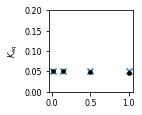

In [155]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq1.svg")
plt.show()

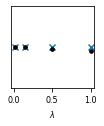

In [156]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq2.svg")
plt.show()

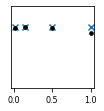

In [157]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq3.svg")
plt.show()

### Association and dissociation rate constants

In [ ]:
# calculate kon from transition probabilities matrix
A01 = association_rate(models[data_path.name].z_map)
A01_low, A01_high = posterior_estimate(z_dist, association_rate)
fit[data_path.name]["A01"] = A01.item()
fit[data_path.name]["A01_low"] = A01_low.item()
fit[data_path.name]["A01_high"] = A01_high.item()

# calculate koff from transition probabilities matrix
A10 = dissociation_rate(models[data_path.name].z_map)
A10_low, A10_high = posterior_estimate(z_dist, dissociation_rate)
fit[data_path.name]["A10"] = A10.item()
fit[data_path.name]["A10_low"] = A10_low.item()
fit[data_path.name]["A10_high"] = A10_high.item()

In [ ]:
# calculate kon from dwell times
dwell_time = unbound_dwell_times(intervals)
kon = 1 / dwell_time.mean()
fit[data_path.name]["kon"] = kon.item()
kon_low, kon_high = sample_and_bootstrap(
    z_dist,
    lambda x: 1 / x.mean(),
    preprocess=lambda x: unbound_dwell_times(count_intervals(x))
)
fit[data_path.name]["kon_low"] = kon_low.item()
fit[data_path.name]["kon_high"] = kon_high.item()

In [16]:
path_data = EXAMLES_DIR / "kon0.03lamda0.15"
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs32"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [17]:
z_marginal = model.z_marginal.data

z = dist.Bernoulli(z_marginal).sample((1000,))

In [28]:
kkon = np.zeros((1000,))
kkoff = np.zeros((1000,))
for i in range(1000):
    intervals = count_intervals(z[i])
    dwell_time = unbound_dwell_times(intervals)
    kkon[i] = 1 / dwell_time.mean()
    
    intervals = count_intervals(z[i])
    dwell_time = bound_dwell_times(intervals)
    kkoff[i] = 1 / dwell_time.mean()

In [18]:
z.shape

torch.Size([1000, 100, 1000])

In [19]:
kon = association_rate(z)

In [21]:
koff = dissociation_rate(z)

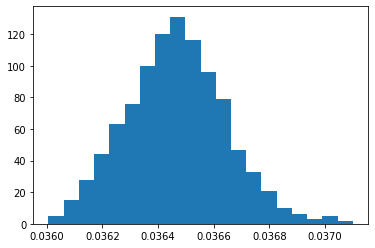

In [25]:
plt.hist(kon.numpy(), bins=20)
plt.show()

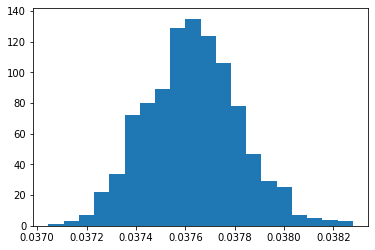

In [27]:
plt.hist(kkon, bins=20)
plt.show()

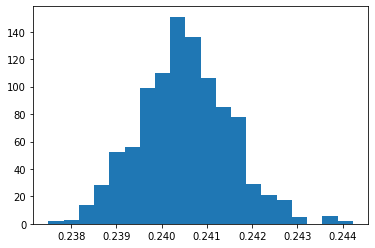

In [29]:
plt.hist(koff.numpy(), bins=20)
plt.show()

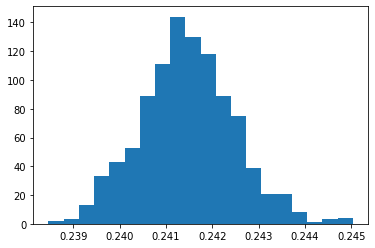

In [30]:
plt.hist(kkoff, bins=20)
plt.show()

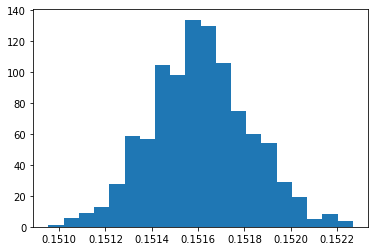

In [31]:
plt.hist(kon.numpy() / koff.numpy(), bins=20)
plt.show()

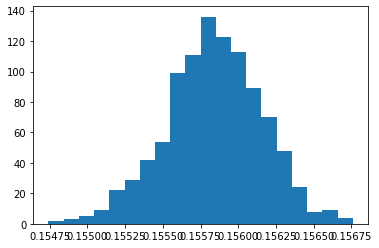

In [32]:
plt.hist(kkon / kkoff, bins=20)
plt.show()

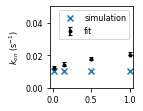

In [147]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x", label="simulation")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
plt.legend(fontsize=8)
plt.savefig("/tmp/kon1-dt.svg")
plt.show()

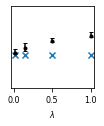

In [150]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x", label="simulation")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
# plt.legend(fontsize=8)
plt.savefig("/tmp/kon2-dt.svg")
plt.show()

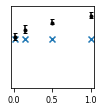

In [151]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/kon3-dt.svg")
plt.show()

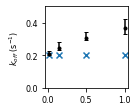

In [152]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff1-dt.svg")
plt.show()

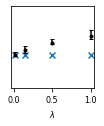

In [153]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff2-dt.svg")
plt.show()

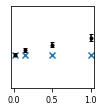

In [154]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff3-dt.svg")
plt.show()

### Traces

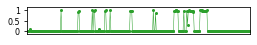

In [27]:
plt.figure(figsize=(4, 0.5))

f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    model.z_marginal[0, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
# plt.ylabel(r"$p$", fontsize=8)
# plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-trace.svg")
plt.show()

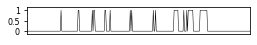

In [29]:
plt.figure(figsize=(4, 0.5))

f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    dist.Bernoulli(model.z_marginal[0, f1:f2]).sample(),
    "-", ms=2, lw=0.5, color="k", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
# plt.ylabel(r"$p$", fontsize=8)
# plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-sample1.svg")
plt.show()

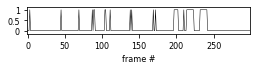

In [56]:
plt.figure(figsize=(4, 0.5))

f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    dist.Bernoulli(model.z_marginal[0, f1:f2]).sample(),
    "-", ms=2, lw=0.5, color="k", label="fit")

plt.xticks(fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
# plt.ylabel(r"$p$", fontsize=8)
plt.xlabel("frame #", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-sample2.svg")
plt.show()

In [44]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"
data_path = EXAMLES_DIR / "kon0.03lamda1"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs32/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

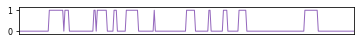

In [45]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    model.data.labels["z"][0, f1:f2],
    "-", lw=1, color="C4", label="simulation")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
# plt.ylabel(r"$p$", fontsize=8)
# plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-sim.svg")
plt.show()

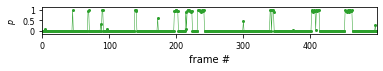

In [47]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 500
plt.plot(
    model.data.drift.index[f1:f2],
    model.z_marginal[0, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="fit")

plt.xticks(fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-trace.svg")
plt.show()

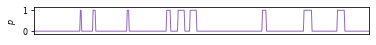

In [50]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 500
plt.plot(
    model.data.drift.index[f1:f2],
    model.data.labels["z"][0, f1:f2],
    "-", lw=1, color="C4", label="simulation")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
# plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-sim.svg")
plt.show()

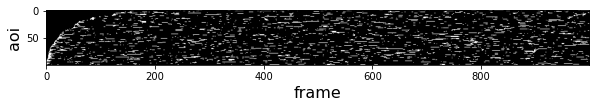

In [12]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)

sdx = np.flip(np.argsort(sttfb))

figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)

plt.imshow(model.data.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()